# PoissonVI: Analyzing quantitative scATAC-seq fragment counts

[PoissonVI](https://www.nature.com/articles/s41592-023-02112-6) is used for analyzing scATAC-seq data using quantitative fragment counts. This tutorial walks through how to read, set-up and train the model, accessing and visualizing the latent space, and differential accessibility. We use the 5kPBMC sample dataset from 10x but these steps can be easily adjusted for other datasets.

If you use PoissonVI, please consider citing:

- Martens, L. D., Fischer, D. S., Yépez, V. A., Theis, F. J., & Gagneur, J. (2023). Modeling fragment counts improves single-cell ATAC-seq analysis. Nature Methods.

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/scvi_colab/_core.py:42: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import ContextualVersionConflict
/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/scvi_colab/_core.py:47: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import os
import tempfile
from pathlib import Path

import pooch
import scanpy as sc
import scvi
import torch

In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.4.2


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [4]:
sc.set_figure_params(figsize=(4, 4), frameon=False)
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor" : "w"}
%config InlineBackend.figure_format="retina"

## Download and preprocess data

First we need to download the sample data - we will use the `pooch` package to do this.

```{note}
For general pre-processing for various datatypes used by scvi-tools models, see the [preprocessing tutorial](https://docs.scvi-tools.org/en/stable/tutorials/notebooks/use_cases/preprocessing.html#scatac-seq).
```

In [5]:
def download_data(save_path: str, fname: str = "atac_pbmc_5k") -> str:
    """Download the data files."""
    data_paths = pooch.retrieve(
        url="https://cf.10xgenomics.com/samples/cell-atac/1.2.0/atac_pbmc_5k_nextgem/atac_pbmc_5k_nextgem_filtered_peak_bc_matrix.tar.gz",
        known_hash="78e536a1508108fa5bd3b411a7484809c011f3403800369b20db05bdbfeb2284",
        fname=fname,
        path=save_path,
        processor=pooch.Untar(),
        progressbar=True,
    )
    return str(Path(data_paths[0]).parent)

In [6]:
data_path = download_data(save_dir.name)

  0%|                                               | 0.00/114M [00:00<?, ?B/s]

Untarring contents of '/tmp/tmpd56sz7xd/atac_pbmc_5k' to '/tmp/tmpd56sz7xd/atac_pbmc_5k.untar'


PoissonVI expects as input an AnnData object with a cell-by-region matrix. There are various pipelines that handle preprocessing of scATAC-seq to obtain this matrix from the sequencing data. If the data was generated by 10x genomics, this matrix is among the standard outputs of CellRanger. Other pipelines, like [SnapATAC](https://github.com/r3fang/SnapATAC/) and [ArchR](https://www.archrproject.com/bookdown/add-peak-matrix.html), also generate similar matrices.

```{important}
In each of these approaches, a **read count matrix** is generated which has more even counts than uneven counts. Due to this, the matrix can not easily be modeled with a standard count distribution. As an alternative, we recommend modeling the **fragment counts**, which are monotonic decreasing. We suggest a straightforward method to convert read counts to fragment counts: round the read counts to the nearest even count and divide by two- which in most cases is very close to the true fragment counts. If you do not want to use the approximation, counting fragments overlapping a peak can be achieved using methods such as the `FeatureMatrix` function in [Signac](https://stuartlab.org/signac/reference/featurematrix), which specifically counts fragments.
```

In the case of 10x data, scvi has a special reader function `scvi.data.read_10x_atac` that reads the files and creates an AnnData object, demonstrated below.

Throughout this tutorial, we use [sample scATACseq data from 10X of 5K PBMCs](https://support.10xgenomics.com/single-cell-atac/datasets/1.2.0/atac_pbmc_5k_nextgem).

In [7]:
adata = scvi.data.read_10x_atac(data_path)
adata

AnnData object with n_obs × n_vars = 4585 × 115554
    obs: 'batch_id'
    var: 'chr', 'start', 'end'

A rapid method for discerning whether a count matrix contains read counts or fragment counts involves a simple count of ones and twos within the matrix. If we have a read count matrix, we expect a higher number of even counts, resulting in a higher frequency of twos compared to ones.

In [8]:
(adata.X == 1).sum()

np.int64(1617289)

In [9]:
(adata.X == 2).sum()

np.int64(25632158)

We can see that we have more twos than ones, which means that we have a read count matrix. In this tutorial, we will use the described approximation to convert them to fragment counts using the `scvi.data.reads_to_fragments` which will store the fragment counts in `adata.layers['fragments']`

In [10]:
scvi.data.reads_to_fragments(adata)

In [11]:
adata

AnnData object with n_obs × n_vars = 4585 × 115554
    obs: 'batch_id'
    var: 'chr', 'start', 'end'
    layers: 'fragments'

If we test again the number of ones and twos for the fragment count layer, we see that we do have more ones that twos:

In [12]:
(adata.layers["fragments"] == 1).sum()

np.int64(27249447)

In [13]:
(adata.layers["fragments"] == 2).sum()

np.int64(7233892)

We can use Scanpy to further handle, filter, and manipulate the data. In our case, we might want to filter out peaks that are rarely detected, to make the model train faster:

In [14]:
print("# regions before filtering:", adata.shape[-1])

# compute the threshold: 5% of the cells
min_cells = int(adata.shape[0] * 0.05)
# in-place filtering of regions
sc.pp.filter_genes(adata, min_cells=min_cells)

print("# regions after filtering:", adata.shape[-1])

# regions before filtering: 115554
# regions after filtering: 33142


## Set up, train, save, and load the model

We can now set up the AnnData object with PoissonVI, which will ensure everything the model needs is in place for training.

This is also the stage where we can condition the model on additional covariates, which encourages the model to remove the impact of those covariates from the learned latent space. Our sample data is a single batch, so we won't demonstrate this directly, but it can be done simply by setting the `batch_key` argument to the annotation to be used as a batch covariate (must be a valid key in `adata.obs`). As the count layer, we will choose the `fragments` layer which contains our converted counts.

In [15]:
scvi.external.POISSONVI.setup_anndata(adata, layer="fragments")

We can now create a PoissonVI model object and train it!

```{important}
The default `max_epochs` is set to `500`, but in practice PoissonVI stops early once the model converges (we quantify convergence with the model's validation reconstruction loss). This is especially the case for larger datasets, which require fewer training epochs to converge since each epoch lets the model view more data. 

This means that the estimated training runtime is usually an overestimate of the actual runtime. For the data used in this tutorial, it typically converges with around half of `max_epochs`!
```

In [16]:
model = scvi.external.POISSONVI(adata)
model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/lightning/pytorch/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.
/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 18673.984. Signaling Trainer to stop.


Since training a model can take a while, we recommend saving the trained model after training, just in case.

In [17]:
model_dir = os.path.join(save_dir.name, "poissonvi_pbmc")

In [18]:
model.save(model_dir, overwrite=True)

We can then load the model later, which require providing an AnnData object that is structured similarly to the one used for training (or, in most cases, the same one):

In [19]:
model = scvi.external.POISSONVI.load(model_dir, adata=adata)

INFO     File /tmp/tmpd56sz7xd/poissonvi_pbmc/model.pt already downloaded                                          


## Visualizing and analyzing the latent space

We can now use the trained model to visualize, cluster, and analyze the data. We first extract the latent representation from the model, and save it back into our AnnData object:

In [20]:
POISSONVI_LATENT_KEY = "X_poissonvi"

latent = model.get_latent_representation()
adata.obsm[POISSONVI_LATENT_KEY] = latent
latent.shape

(4585, 13)

We can now use Scanpy to cluster and visualize our latent space:

In [21]:
POISSONVI_CLUSTERS_KEY = "clusters_poissonvi"

# compute the k-nearest-neighbor graph that is used in both clustering and umap algorithms
sc.pp.neighbors(adata, use_rep=POISSONVI_LATENT_KEY)
# compute the umap
sc.tl.umap(adata, min_dist=0.2)
# cluster the space (we use a lower resolution to get fewer clusters than the default)
sc.tl.leiden(adata, key_added=POISSONVI_CLUSTERS_KEY, resolution=0.2)

/tmp/ipykernel_101936/2628586055.py:8: FutureWarning: The `igraph` implementation of leiden clustering is *orders of magnitude faster*. Set the flavor argument to (and install if needed) 'igraph' to use it.
In the future, the default backend for leiden will be igraph instead of leidenalg. To achieve the future defaults please pass: `flavor='igraph'` and `n_iterations=2`. `directed` must also be `False` to work with igraph’s implementation.
  sc.tl.leiden(adata, key_added=POISSONVI_CLUSTERS_KEY, resolution=0.2)


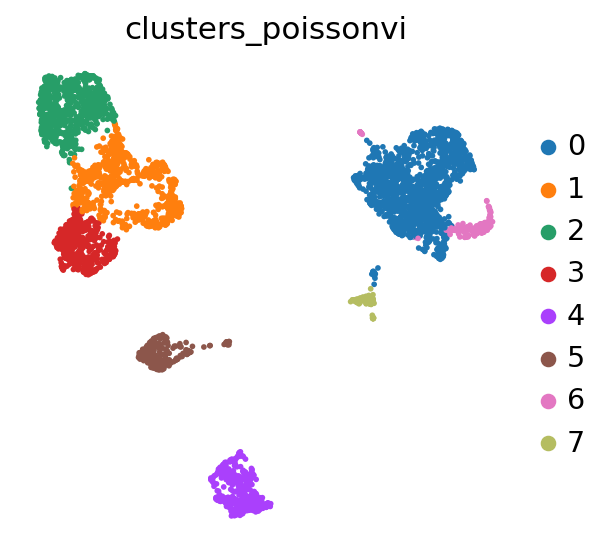

In [22]:
sc.pl.umap(adata, color=POISSONVI_CLUSTERS_KEY)

## Differential accessibility

Finally, we can use PoissonVI to identify regions that are differentially accessible. There are many different ways to run this analysis, but the simplest is comparing one cluster against all others, or comparing two clusters to each other. In this case we'll be looking for marker-regions, so we'll mostly want a one-sided test (the significant regions will only be the ones preferentially accessible in our target cluster).

```{important}
If the data includes multiple batches, we encourage setting `batch_correction=True` so the model will sample from multiple batches when computing the differential signal. 
```

In [23]:
da_peaks = model.differential_accessibility(
    adata, groupby=POISSONVI_CLUSTERS_KEY, group1="3", mode="vanilla", two_sided=False
)

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

We will filter the results for peaks that are accessible in the cluster by filtering for peaks that are at least present in 5% of the cells in the cluster (`emp_prob1 > 0.05`).

In [24]:
da_peaks_filt = da_peaks[(da_peaks.emp_prob1 >= 0.05)]

In [25]:
da_peaks_filt.head(10)

,proba_m1,proba_m2,bayes_factor,scale1,scale2,emp_prob1,emp_prob2,emp_effect,comparison,group1,group2
chr16:23493881-23495402,0.9990,0.0010,6.906745,0.000079,0.000003,0.487854,0.019800,0.468055,3 vs Rest,3,Rest
chr22:27052873-27055430,0.9990,0.0010,6.906745,0.000045,0.000017,0.352227,0.152530,0.199697,3 vs Rest,3,Rest
chr16:27411973-27420447,0.9980,0.0020,6.212601,0.000140,0.000053,0.676113,0.348814,0.327299,3 vs Rest,3,Rest
chr16:81751220-81753358,0.9978,0.0022,6.117091,0.000028,0.000008,0.216599,0.063554,0.153045,3 vs Rest,3,Rest
chr1:85492870-85493850,0.9976,0.0024,6.029880,0.000024,0.000005,0.216599,0.045466,0.171134,3 vs Rest,3,Rest
chr17:46723577-46725424,0.9976,0.0024,6.029880,0.000019,0.000007,0.157895,0.057443,0.100452,3 vs Rest,3,Rest
chr18:77933028-77933973,0.9974,0.0026,5.949637,0.000054,0.000004,0.331984,0.029577,0.302407,3 vs Rest,3,Rest
chr22:39941298-39942262,0.9966,0.0034,5.680571,0.000018,0.000004,0.163968,0.037155,0.126813,3 vs Rest,3,Rest
chr3:111334713-111336070,0.9966,0.0034,5.680571,0.000032,0.000007,0.261134,0.060865,0.200268,3 vs Rest,3,Rest
chr2:242807595-242811851,0.9966,0.0034,5.680571,0.000067,0.000010,0.423077,0.085309,0.337768,3 vs Rest,3,Rest


We can visualize the marker peaks of cluster 3:

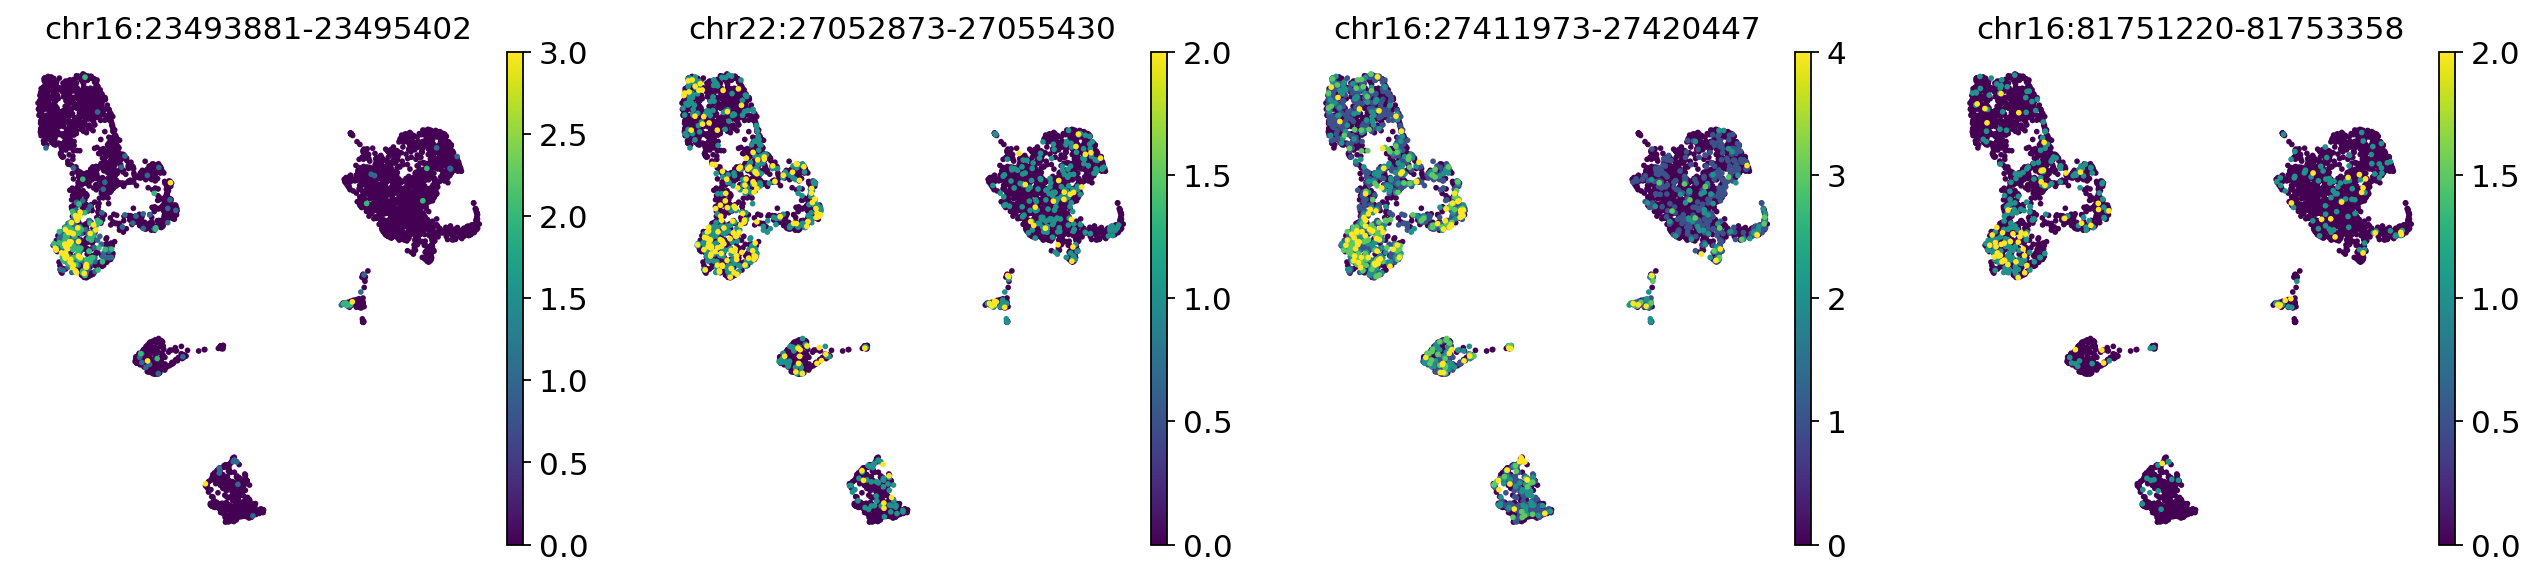

In [26]:
sc.pl.umap(adata, color=da_peaks_filt.index[:4], layer="fragments", vmax="p99.0")